In [1]:
import networkx as nx
import numpy as np
from queue import PriorityQueue
import ipywidgets as widgets
from copy import deepcopy
import torch
from utils import *
import torch.nn as nn
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
import logging

In [2]:


# Configure logging to output to PyCharm's console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

def add_node_with_edges(graph, node_name):
    """
    Add a node to the graph and allow the user to input related edges with direction using widgets in Jupyter Notebook.
    Displays immediate edge information on addition and logs actions to console.

    Parameters:
    graph (nx.DiGraph): The directed graph to add the node and edges to.
    node_name (str): The name of the node to add.

    Returns:
    None
    """
    # Add the node to the graph
    graph.add_node(node_name)
    display(HTML(f"<b>Notification:</b> Node '{node_name}' has been added to the graph."))
    logger.info(f"Node '{node_name}' has been added to the graph.")

    # Define output widget
    global node_dropdown, user_text, root_text, direction_dropdown, output
    output = widgets.Output()

    # Function to handle edge addition
    def add_edge(b):
        with output:
            clear_output(wait=True)
            display(HTML(f"<b>Notification:</b> Node '{node_name}' has been added to the graph."))
            logger.info(f"Add Edge button clicked for node '{node_name}'.")
            
            try:
                # Get widget values
                target_node = node_dropdown.value
                user_prob = float(user_text.value)
                root_prob = float(root_text.value)
                direction = direction_dropdown.value
                
                # Validate probabilities
                if not (0.0 <= user_prob <= 1.0 and 0.0 <= root_prob <= 1.0):
                    display(HTML("<b>Error:</b> Probabilities must be in the range [0.0, 1.0]. Please try again."))
                    logger.error(f"Invalid probabilities: user={user_prob}, root={root_prob}")
                    return
                
                # Prepare edge information
                edge_info = f"Edge Info: user={user_prob}, root={root_prob}, direction={direction}"
                
                # Add edge based on direction
                if direction == "To Target":
                    graph.add_edge(node_name, target_node, user=user_prob, root=root_prob)
                    edge_msg = f"Edge from '{node_name}' to '{target_node}' ({edge_info})"
                elif direction == "From Target":
                    graph.add_edge(target_node, node_name, user=user_prob, root=root_prob)
                    edge_msg = f"Edge from '{target_node}' to '{node_name}' ({edge_info})"
                else:  # Bidirectional
                    graph.add_edge(node_name, target_node, user=user_prob, root=root_prob)
                    graph.add_edge(target_node, node_name, user=user_prob, root=root_prob)
                    edge_msg = f"Bidirectional edge between '{node_name}' and '{target_node}' ({edge_info})"
                
                # Display and log edge info immediately
                display(HTML(f"<b>Notification:</b> {edge_msg} has been added."))
                logger.info(f"{edge_msg} has been added.")
                display_widgets()  # Redisplay widgets for next edge
            except ValueError:
                display(HTML("<b>Error:</b> Invalid input for probabilities. Please enter valid numbers."))
                logger.error("Invalid input for probabilities.")

    # Function to handle stopping
    def stop_adding(b):
        with output:
            clear_output(wait=True)
            display(HTML(f"<b>Notification:</b> Finished adding edges for node '{node_name}'."))
            logger.info(f"Finished adding edges for node '{node_name}'.")

    # Function to display widgets
    def display_widgets():
        with output:
            clear_output(wait=True)
            # Get list of existing nodes
            existing_nodes = list(graph.nodes())
            if not existing_nodes:
                display(HTML("<b>Warning:</b> No existing nodes in the graph."))
                logger.warning("No existing nodes in the graph.")
                return
            
            # Create widgets
            global node_dropdown, user_text, root_text, direction_dropdown
            node_dropdown = widgets.Dropdown(
                options=existing_nodes,
                description='Target Node:',
                disabled=False
            )
            user_text = widgets.FloatText(
                value=0.0,
                description='User Prob:',
                style={'description_width': 'initial'}
            )
            root_text = widgets.FloatText(
                value=0.0,
                description='Root Prob:',
                style={'description_width': 'initial'}
            )
            direction_dropdown = widgets.Dropdown(
                options=["To Target", "From Target", "Bidirectional"],
                description='Edge Direction:',
                disabled=False
            )
            add_button = widgets.Button(description="Add Edge")
            stop_button = widgets.Button(description="Stop")

            # Assign button callbacks with debug logging
            def on_add_button_clicked(b):
                logger.info("Add Edge button event triggered.")
                add_edge(b)
            
            def on_stop_button_clicked(b):
                logger.info("Stop button event triggered.")
                stop_adding(b)

            add_button.on_click(on_add_button_clicked)
            stop_button.on_click(on_stop_button_clicked)

            # Display widgets and initial message
            display(HTML(f"<b>Adding edges from/to '{node_name}':</b>"))
            display(node_dropdown, user_text, root_text, direction_dropdown, add_button, stop_button)

    # Initial display of widgets
    display(output)
    display_widgets()

In [3]:
# Original graph setup
G_original = nx.DiGraph()
edges = [
    ("Attacker", "Pad", {"user": 0.6, "root": 0.6}),
    ("Attacker", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Attacker", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Pad", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Pad", {"user": 0.6, "root": 0.6}),
    ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}),
    ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
    ("Host 3", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Web Server", "File Server", {"user": 0.8, "root": 0.04}),
    ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),
    ("File Server", "Data Server", {"user": 0.8, "root": 0.04})
]
G_original.add_edges_from(edges)

G_new = G_original.copy()
add_node_with_edges(G_new, "New node")



2025-06-07 00:02:39,811 - INFO - Node 'New node' has been added to the graph.


Output()

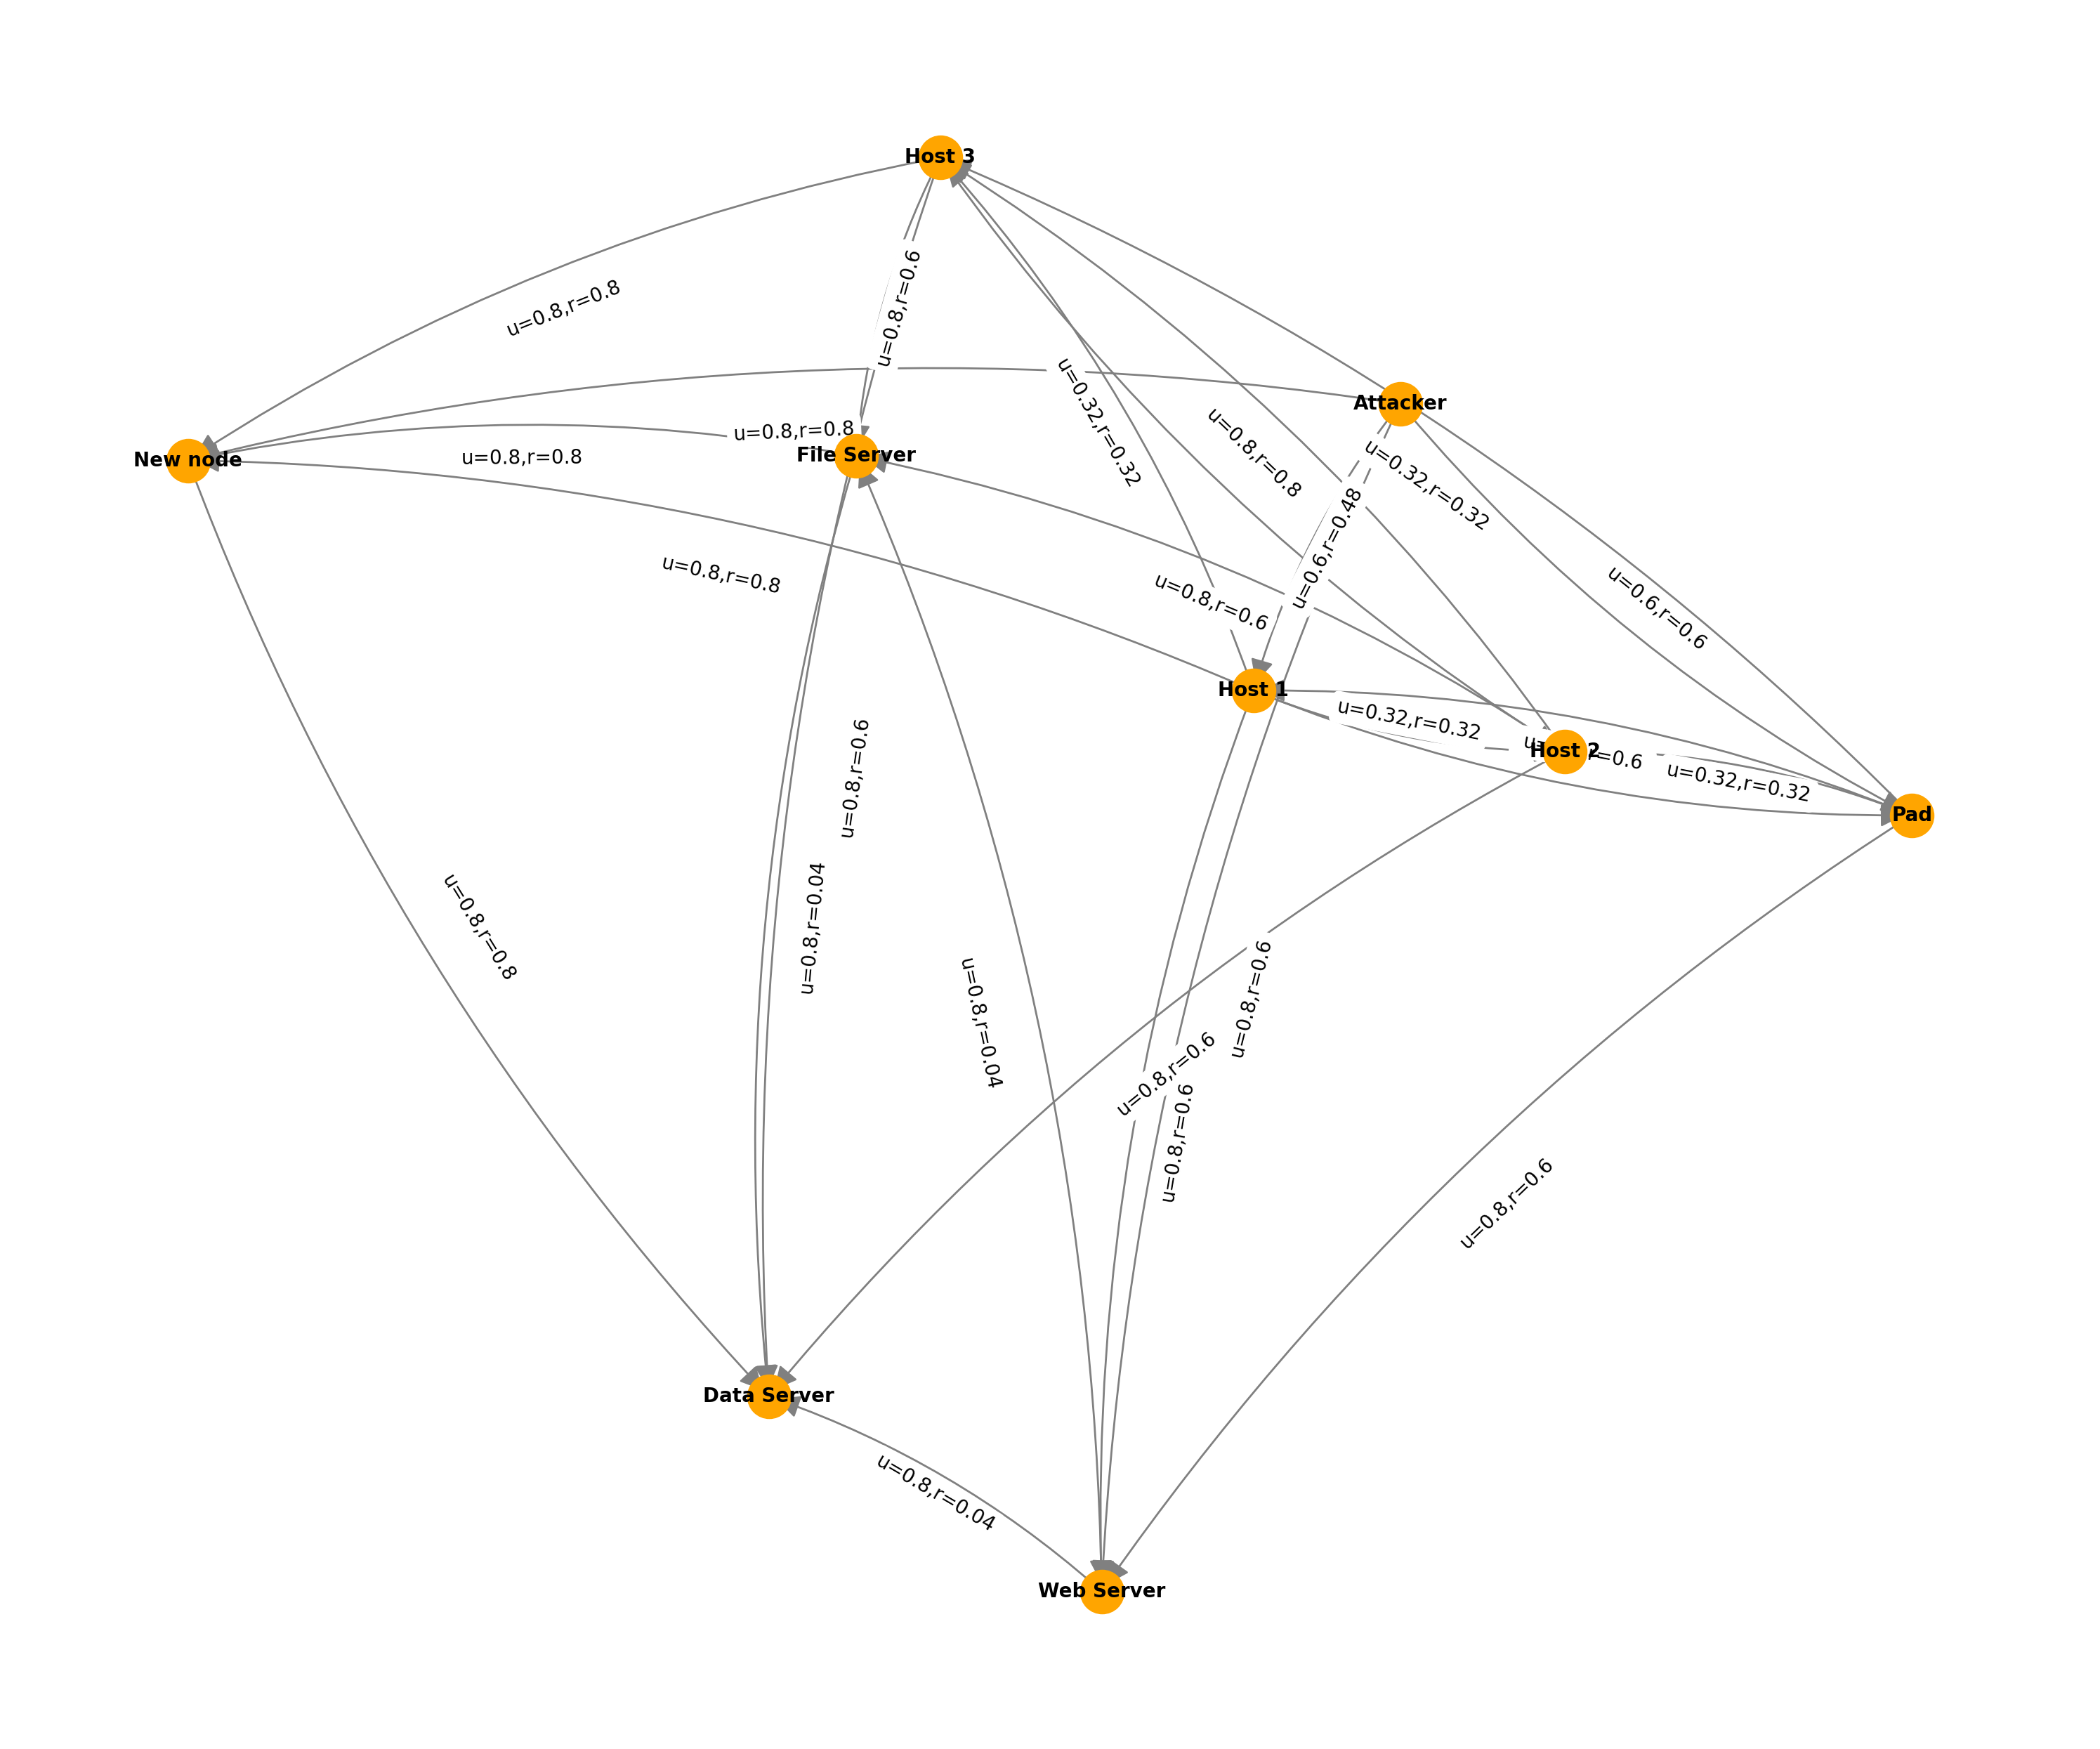

In [4]:

plt.figure(figsize=(30, 25))

# Cố định layout để lần nào cũng ra vị trí giống nhau
pos = nx.spring_layout(G_new, seed=42)

# Vẽ nodes
nx.draw_networkx_nodes(G_new, pos, node_color='orange', node_size=2000)

# Vẽ labels nodes
nx.draw_networkx_labels(G_new, pos, font_size=20, font_weight='bold')

# Vẽ edges với mũi tên và màu xám
nx.draw_networkx_edges(
    G_new, pos,
    edge_color='gray',
    arrows=True,
    arrowsize=50,
    width=2,
    connectionstyle='arc3,rad=0.1'  # Cạnh hơi cong cho đẹp
)

# Vẽ label trọng số cạnh
edge_labels = {(u, v): f"u={d['user']},r={d['root']}" for u, v, d in G_new.edges(data=True)}
nx.draw_networkx_edge_labels(G_new, pos, edge_labels=edge_labels, font_size=20)

plt.axis('off')
plt.tight_layout()

plt.savefig("graph.png")
plt.show()


In [5]:

class DQNWithBias(nn.Module):
    def __init__(self, base_model, old_num_nodes, new_num_nodes):
        super().__init__()
        self.model = base_model
        self.old_num_nodes = old_num_nodes
        self.new_num_nodes = new_num_nodes
        self.old_space_size = 2 * old_num_nodes**2 
        self.new_space_size = 2 * new_num_nodes**2 
        self.alpha = nn.Parameter(torch.Tensor([1]))
        self.beta = nn.Parameter(torch.Tensor([0]))
        
        # Tạo mask phân biệt action cũ và mới dựa trên cantor pairing
        self.register_buffer('is_old_mask', self._create_old_mask())

    def _is_old_action(self, idx):
        x, y = inverse_cantor(idx)
        return x < self.old_num_nodes and y < self.old_num_nodes
    def _create_old_mask(self):
        mask = []
        for idx in range(self.new_space_size):
            mask.append(self._is_old_action(idx))
        return torch.tensor(mask, dtype=torch.bool)

    def forward(self, x):
        q_raw = self.model(x)  # shape: [batch_size, new_space_size]

        # Tách q_old và q_new bằng mask
        q_old = q_raw[:, self.is_old_mask]        # các action cũ
        q_new = q_raw[:, ~self.is_old_mask]       # các action mới

        # Áp dụng correction chỉ với phần action mới
        q_new_corrected = self.alpha * q_new + self.beta

        # Kết hợp lại theo thứ tự action ban đầu
        # Tạo tensor rỗng và điền giá trị theo mask
        q_corrected = torch.empty_like(q_raw)
        q_corrected[:, self.is_old_mask] = q_old
        q_corrected[:, ~self.is_old_mask] = q_new_corrected
        
        return q_corrected

In [6]:
old_num_nodes = G_original.number_of_nodes() - 2
new_num_nodes = G_new.number_of_nodes() - 2

old_action_space_size = 2*old_num_nodes**2 
new_action_space_size = 2*new_num_nodes**2 

model_old =  DQN(old_num_nodes, old_action_space_size)
model_load = torch.load("./Saved_Model/dqn_model.pth")
model_old.load_state_dict(model_load['policy_net_state_dict'])
model_new = DQN(new_num_nodes, new_action_space_size)


# 
with torch.no_grad():
    # Copy fc1, fc2, fc3 như bình thường
    model_new.fc1.weight[:, :old_num_nodes] = model_old.fc1.weight[:, :old_num_nodes]
    model_new.fc1.bias.copy_(model_old.fc1.bias)
    model_new.fc2.load_state_dict(model_old.fc2.state_dict())
    model_new.fc3.load_state_dict(model_old.fc3.state_dict())

    # Tập chỉ số toàn bộ action mới
    all_new_indices = set(range(new_action_space_size))

    # Tập các chỉ số action cũ đã copy
    old_indices_mapped = set()
    for old_idx in range(old_action_space_size):
        i, j = inverse_cantor(old_idx)
        if i < old_num_nodes and j < old_num_nodes:
            model_new.fc4.weight[old_idx].copy_(model_old.fc4.weight[old_idx])
            model_new.fc4.bias[old_idx].copy_(model_old.fc4.bias[old_idx])
            old_indices_mapped.add(old_idx)

    new_indices = list(all_new_indices - old_indices_mapped)

    # Khởi tạo phần mở rộng fc4.weight, bias cho các chỉ số mới
    for idx in new_indices:
        torch.nn.init.xavier_uniform_(model_new.fc4.weight[idx:idx+1])
        model_new.fc4.bias[idx] = 0.0

    torch.nn.init.xavier_uniform_(model_new.fc1.weight[:, old_num_nodes:])


In [7]:
print("FC4 weights:")
print(model_new.fc4.weight)

print("\nFC4 bias:")
print(model_new.fc4.bias)

FC4 weights:
Parameter containing:
tensor([[ 0.0931,  0.0760,  0.0465,  ..., -0.0826,  0.1164, -0.0049],
        [ 0.0429,  0.1564, -0.0040,  ..., -0.0460, -0.0186,  0.1148],
        [ 0.0309,  0.0020,  0.0750,  ..., -0.0501,  0.0668,  0.0880],
        ...,
        [-0.2356, -0.0276,  0.2660,  ...,  0.2506,  0.0054, -0.2354],
        [-0.2898,  0.1901,  0.0136,  ...,  0.1452, -0.1457,  0.2525],
        [ 0.2165, -0.2675,  0.0908,  ..., -0.0731,  0.1063, -0.0463]],
       requires_grad=True)

FC4 bias:
Parameter containing:
tensor([-0.0025,  0.0649,  0.1663,  0.0052,  0.0361,  0.1483,  0.0166,  0.1068,
         0.0483, -0.0008,  0.0294, -0.0208, -0.0157, -0.2818, -0.2286, -0.0526,
        -0.0361, -0.0599, -0.1005, -0.0539,  0.0202,  0.0000, -0.0639, -0.2227,
         0.0677, -0.0399, -0.0919,  0.0000,  0.0000,  0.0000,  0.0215, -0.0531,
        -0.1807, -0.0112,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1811,
         0.1153, -0.0997,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 

In [8]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Khởi tạo môi trường và mô hình
env = NetworkSecurityEnv(G_new, global_weighted_random_attack)
model = DQNWithBias(model_new, old_num_nodes, new_num_nodes)

for name, param in model.model.named_parameters():
   if not ("fc4" in name or "fc1" in name):
        param.requires_grad = False

optimizer = torch.optim.SGD([
    {'params': [model.alpha], 'weight_decay': 0.0},
    {'params': [model.beta], 'weight_decay': 1e-4},
    {'params': [p for n, p in model.model.named_parameters() if "fc4" in n or "fc1" in n], 'weight_decay': 1e-4}
], lr=0.05, momentum=0.5)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, verbose=True, min_lr=1e-5)
criterion = nn.MSELoss()


replay_buffer = ReplayBuffer(capacity=10000)



target_update_freq = batch_size = 10
num_episodes = batch_size * 30
losses = []

alpha_history = []
beta_history = []
episode_history = []


successes = 0
for episode in range(1, num_episodes + 1):
    state = env.reset()
    done = False
    total_loss = 0
    episode_steps = 0
    exploration_counter = defaultdict(int)
    exploration_done = False

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        if not exploration_done:
            action_idx = sample_exploration_index(new_action_space_size, new_num_nodes, old_num_nodes, exploration_counter, 15)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = model_new(state_tensor).squeeze(0)  # shape: [action_space_size]

                # Lọc q_values chỉ lấy index hợp lệ
                valid_indices = [idx for idx in range(new_action_space_size) if is_valid_index(idx, new_num_nodes)]
                valid_q_values = q_values[valid_indices]
                # Lấy chỉ số trong valid_indices có q_value max
                max_idx_in_valid = torch.argmax(valid_q_values).item()
                # Map về action_idx thực
                action_idx = valid_indices[max_idx_in_valid]

        action = index_to_action(action_idx, new_num_nodes)
        next_state, reward, done, path, captured = env.step(action)
        replay_buffer.push(state, action_idx, reward, next_state, done)
        state = next_state
        episode_steps += 1



        honeypot_nodes = []
        for i in range(2):
            node_idx = np.argmax(action[i])
            honeypot_nodes.append(env.nodes[node_idx])

        print("Episode:", episode)
        if reward == 1:
            print(path)
            print(f"Success\nHoneypots: {action}\nHoneypots connected to: {honeypot_nodes}\n")
            successes += 1
        elif reward == -1:
            print(path)
            print(f"Failed\nHoneypots: {action}\nHoneypots connected to: {honeypot_nodes}\n")

        # Train từ buffer
        # Train từ buffer
        if len(replay_buffer) >= batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            states_tensor = torch.FloatTensor(states)
            actions_tensor = torch.LongTensor(actions)
            rewards_tensor = torch.FloatTensor(rewards)
            next_states_tensor = torch.FloatTensor(next_states)
            dones_tensor = torch.FloatTensor(dones)
        
            if not (actions_tensor >= 0).all() or not (actions_tensor < new_action_space_size).all():
                print(f"Invalid actions in batch at episode {episode}")
                continue
        
            optimizer.zero_grad()
            q_pred = model(states_tensor)  # shape: [batch_size, action_space_size]
        
            if torch.isnan(q_pred).any() or torch.isinf(q_pred).any():
                print(f"Warning: NaN or Inf in q_pred at episode {episode}")
                continue
        
            q_pred_actions = q_pred.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)  # lấy giá trị Q của action đã chọn
        
            with torch.no_grad():
                q_next = model(next_states_tensor)
                q_next_max = q_next.max(1)[0]
                q_target = rewards_tensor + (1 - dones_tensor) * 0.99 * q_next_max
        
            loss = criterion(q_pred_actions, q_target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


    avg_loss = total_loss / max(episode_steps, 1)
    if episode >= batch_size:
        losses.append(avg_loss)
        scheduler.step(avg_loss)


    if episode % target_update_freq == 0:
        current_lr = optimizer.param_groups[0]['lr']
        alpha_history.append(model.alpha.item())
        beta_history.append(model.beta.item())
        episode_history.append(episode)
    
dsp = (successes / num_episodes) * 100
print(f"\nDefense success probability: {dsp:.2f}%")

/home/hoangvu/miniconda3/envs/pt_cuda_11.8/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Episode: 1
['Attacker', 'Web Server', 'Host 1', 'Honeypot {Host 1}']
Success
Honeypots: [[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]]
Honeypots connected to: ['New node', 'Host 1']

Episode: 2
['Attacker', 'New node', 'Honeypot {New node}']
Success
Honeypots: [[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]]
Honeypots connected to: ['New node', 'Host 1']

Episode: 3
['Attacker', 'New node', 'Honeypot {New node}']
Success
Honeypots: [[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]]
Honeypots connected to: ['New node', 'File Server']

Episode: 4
['Attacker', 'New node', 'Pad', 'Host 3', 'Host 1', 'Data Server']
Failed
Honeypots: [[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
Honeypots connected to: ['Host 1', 'New node']

Episode: 5
['Attacker', 'Pad', 'Host 1', 'Web Server', 'Host 3', 'File Server', 'Data Server']
Failed
Honeypots: [[0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
Honeypots connected to: ['File Server', 'New node']

Episode: 6
['Attacker', 'Host 1', 'Web Server', 'Fil

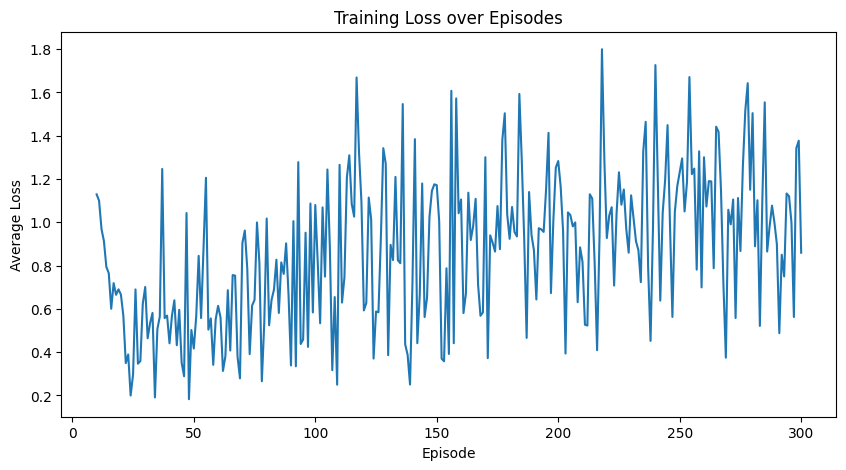

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(batch_size, num_episodes + 1), losses)
plt.xlabel('Episode')
plt.ylabel('Average Loss')
plt.title('Training Loss over Episodes')
plt.show()


In [10]:
print("FC4 weights:")
print(model_new.fc4.weight)

print("\nFC4 bias:")
print(model_new.fc4.bias)
print(np.argmax(model_new.fc4.weight.detach().numpy()))

print(np.argmax(model_new.fc4.bias.detach().numpy()))


FC4 weights:
Parameter containing:
tensor([[ 0.0930,  0.0759,  0.0465,  ..., -0.0825,  0.1163, -0.0049],
        [ 0.0429,  0.1563, -0.0040,  ..., -0.0460, -0.0186,  0.1148],
        [ 0.0309,  0.0020,  0.0750,  ..., -0.0500,  0.0668,  0.0879],
        ...,
        [-0.2355, -0.0276,  0.2659,  ...,  0.2505,  0.0053, -0.2353],
        [-0.2896,  0.1900,  0.0136,  ...,  0.1452, -0.1456,  0.2524],
        [ 0.2164, -0.2673,  0.0908,  ..., -0.0731,  0.1062, -0.0462]],
       requires_grad=True)

FC4 bias:
Parameter containing:
tensor([-0.0025,  0.0649,  0.1663,  0.0052,  0.0361,  0.1482,  0.0166,  0.1068,
         0.0482, -0.0008,  0.0294, -0.0208, -0.0157, -0.2816, -0.2284, -0.0525,
        -0.0361, -0.0598, -0.1005, -0.0538,  0.0201, -0.2727, -0.0638, -0.2226,
         0.0676, -0.0398, -0.0919,  0.2787,  0.0000, -0.1691,  0.0215, -0.0531,
        -0.1807, -0.0112, -0.0553,  0.0000,  0.0000,  0.0000,  0.2318, -0.1810,
         0.1152, -0.0997,  0.1080,  0.0000,  0.0000,  0.0000,  0.0000, 

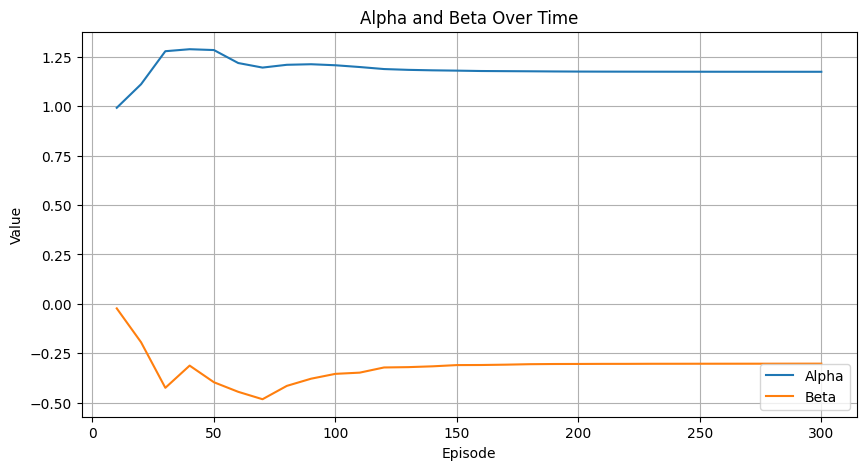

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(episode_history, alpha_history, label='Alpha')
plt.plot(episode_history, beta_history, label='Beta')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Alpha and Beta Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
evaluate_model(model, env)

Episode: 1
['Attacker', 'New node', 'Web Server', 'Pad', 'Host 2', 'File Server', 'Data Server']
Failed
Honeypots: [[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]]
Honeypots connected to: ['New node', 'File Server']

Episode: 2
['Attacker', 'Pad', 'New node', 'Web Server', 'Data Server']
Failed
Honeypots: [[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]]
Honeypots connected to: ['New node', 'File Server']

Episode: 3
['Attacker', 'Pad', 'New node', 'Honeypot {New node}']
Success
Honeypots: [[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]]
Honeypots connected to: ['New node', 'File Server']

Episode: 4
['Attacker', 'Web Server', 'Host 1', 'Host 2', 'Pad', 'File Server', 'New node', 'Host 3', 'Data Server']
Failed
Honeypots: [[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]]
Honeypots connected to: ['New node', 'File Server']

Episode: 5
['Attacker', 'Host 1', 'Web Server', 'Pad', 'New node', 'Host 3', 'Data Server']
Failed
Honeypots: [[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]]
Honeypot